# Evolution

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')


Downloaded utils.py


In [3]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

## The Fitness landscape

A genotype is represented by a length-N array of 0s and 1.

The fitness landscape maps from each location in N-D space to a random fitness.


In [4]:
class FitnessLandscape:
    
    def __init__(self, N):
        """Create a fitness landscape.
        
        N: number of dimensions
        """
        self.N = N
        self.set_values()
        
    def set_values(self):
        self.one_values = np.random.random(self.N)
        self.zero_values = np.random.random(self.N)

    def random_loc(self):
        """Choose a random location."""
        return np.random.randint(2, size=self.N, dtype=np.int8)
    
    def fitness(self, loc):
        """Evaluates the fitness of a location.
        
        loc: array of N 0s and 1s
        
        returns: float fitness
        """
        fs = np.where(loc, self.one_values, self.zero_values)
        return fs.mean()
    
    def distance(self, loc1, loc2):
        return np.sum(np.logical_xor(loc1, loc2))

As an example, here's a 3-D landscape.

In [5]:
fit_land = FitnessLandscape(3)
fit_land.N

3

`one_values` and `zero_values` contain the fitness contributions of having a 1 or 0 at each element of the location array.

In [6]:
fit_land.one_values, fit_land.zero_values

(array([0.04314642, 0.72277958, 0.66395907]),
 array([0.85682641, 0.41488396, 0.58265893]))

The fitness of a location is the mean of its fitness contributions.

In [7]:
loc = fit_land.random_loc()
loc

array([1, 1, 0], dtype=int8)

In [8]:
a = np.where(loc, fit_land.one_values, fit_land.zero_values)
a, np.mean(a)

(array([0.04314642, 0.72277958, 0.58265893]), 0.4495283111471379)

`fitness` evaluates the fitness of a location.

In [9]:
loc, fit_land.fitness(loc)

(array([1, 1, 0], dtype=int8), 0.4495283111471379)

`distance` computes the number of bit flips to get from one location to another.

In [10]:
loc1 = fit_land.random_loc()
loc2 = fit_land.random_loc()
print(loc1)
print(loc2)
fit_land.distance(loc1, loc2)

[1 1 0]
[1 1 1]


1

It uses `np.logical_xor`

In [11]:
np.logical_xor(loc1, loc2)

array([False, False,  True])

## The agents

Here's the class that represents agents.

In [12]:
class Agent:
    """Represents an agent in an NK model."""
    
    def __init__(self, loc, fit_land):
        """Create an agent at the given location.
        
        loc: array of N 0s and 1s
        fit_land: reference to an fit_land
        """
        self.loc = loc
        self.fit_land = fit_land
        self.fitness = fit_land.fitness(self.loc)
        
    def copy(self):
        return Agent(self.loc, self.fit_land)

Each agent has a location, a reference to a FitnessLandscape, and a fitness.

In [13]:
loc = fit_land.random_loc()
agent = Agent(loc, fit_land)
agent.loc, agent.fitness

(array([1, 0, 1], dtype=int8), 0.37399648157162274)

## The Simulator

The `Simulator` class provides methods to run the simulations.


In [14]:
class Simulation:
    
    def __init__(self, fit_land, agents):
        """Create the simulation:
        
        fit_land: fit_land
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=500):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        n = len(self.agents)
        fits = self.get_fitnesses()
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

We'll use a few functions to create agents.  The first one starts with identical agents:

In [15]:
def make_identical_agents(fit_land, num_agents, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    loc = fit_land.random_loc()
    agents = [agent_maker(loc, fit_land) for _ in range(num_agents)]
    return np.array(agents)

Here's another that starts with agents at random locations:

In [16]:
def make_random_agents(fit_land, num_agents, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    num_agents: integer
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    locs = [fit_land.random_loc() for _ in range(num_agents)]
    agents = [agent_maker(loc, fit_land) for loc in locs]
    return np.array(agents)

And this one puts one agent at every possible location:

In [17]:
import itertools

def make_all_agents(fit_land, agent_maker):
    """Make an array of Agents.
    
    fit_land: FitnessLandscape
    agent_maker: class used to make Agent
    
    returns: array of Agents
    """
    N = fit_land.N
    locations = itertools.product([0, 1], repeat=N)
    agents = [agent_maker(loc, fit_land) for loc in locations]
    return np.array(agents)

`make_all_agents` uses `itertools.product`, which returns a generator that enumerates the Cartesian product of the set `{0, 1}` with itself `N` times, which is a fancy way to say that it enumerates all sequences of `N` bits.  Here's an example:

In [18]:
fit_land = FitnessLandscape(3)
agents = make_all_agents(fit_land, Agent)
for agent in agents:
    print(agent.loc, agent.fitness)

(0, 0, 0) 0.23963622962659867
(0, 0, 1) 0.25664496944295917
(0, 1, 0) 0.4300377880390322
(0, 1, 1) 0.44704652785539273
(1, 0, 0) 0.32778281008149546
(1, 0, 1) 0.344791549897856
(1, 1, 0) 0.518184368493929
(1, 1, 1) 0.5351931083102895


## The distribution of fitness

Let's create a fitness landscape with an agent at each location and see what the distribution of fitness looks like.

In [19]:
np.random.seed(17)

N = 8
fit_land = FitnessLandscape(N)
agents = make_all_agents(fit_land, Agent)
sim = Simulation(fit_land, agents)

`plot_fitnesses` plots the CDF of fitness across the population.

In [20]:
from empiricaldist import Cdf

def plot_fitnesses(sim):
    """Plot the CDF of fitnesses.
    
    sim: Simulation object
    """
    fits = sim.get_fitnesses()
    cdf_fitness = Cdf.from_seq(fits)
    cdf_fitness.plot()
    return np.mean(fits)

Initially the distribution is approximately Gaussian, because it's the sum of 8 independent uniformly distributed variates.  See the Central Limit Theorem.

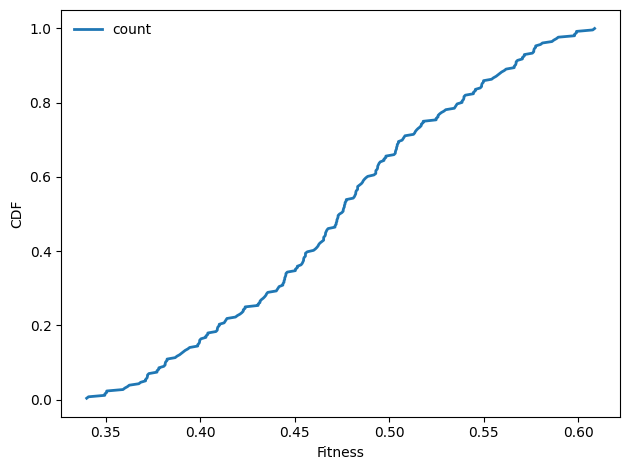

In [21]:
plot_fitnesses(sim)
decorate(xlabel='Fitness', ylabel='CDF')

After one time step, there's not much change.

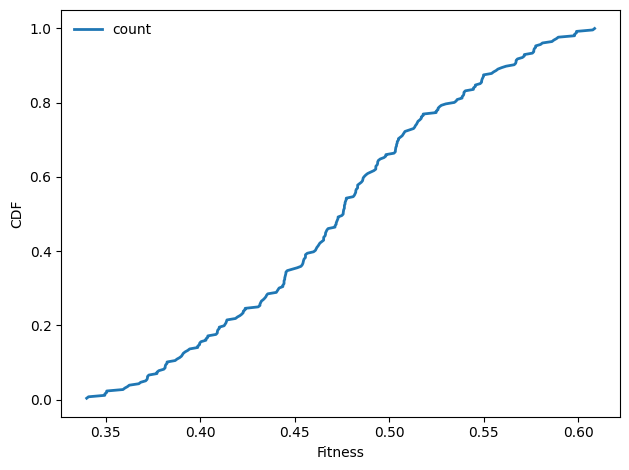

In [22]:
sim.step()
plot_fitnesses(sim)
decorate(xlabel='Fitness', ylabel='CDF')

After 100 time steps, we can see that the number of unique values has decreased.

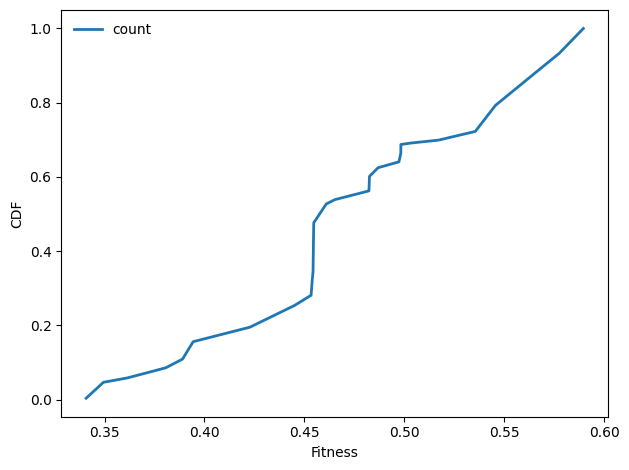

In [23]:
sim.run(100)
plot_fitnesses(sim)
decorate(xlabel='Fitness', ylabel='CDF')

## Instruments

To measure these changes over the course of the simulations, we'll use Instrument objects.

In [24]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
        
    def plot(self, **options):
        plt.plot(self.metrics, **options)

The `MeanFitness` instrument computes the mean fitness after each time step.

In [25]:
class MeanFitness(Instrument):
    """Computes mean fitness at each timestep."""
    label = 'Mean fitness'
    
    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

Here's mean fitness as a function of (simulated) time for a single run.

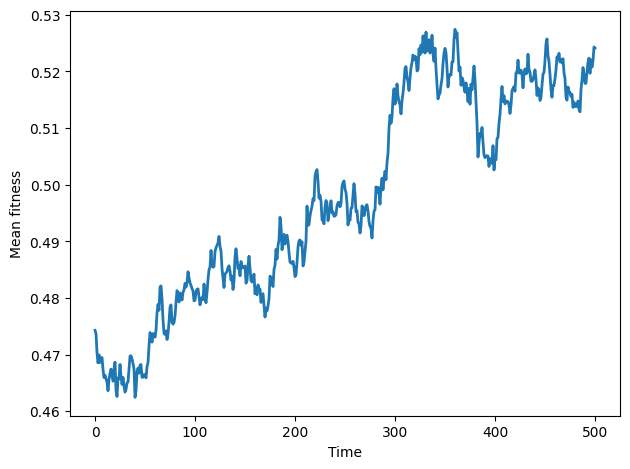

In [26]:
np.random.seed(17)

N = 8
fit_land = FitnessLandscape(N)
agents = make_all_agents(fit_land, Agent)

sim = Simulation(fit_land, agents)
instrument = MeanFitness()
sim.add_instrument(instrument)
sim.run(500)
sim.plot(index=0)

decorate(xlabel='Time', ylabel='Mean fitness')

We can get a better sense of average behavior, and variation around the average, but plotting multiple runs.

In [27]:
def plot_sims(fit_land, agent_maker, sim_maker, instrument_maker, **plot_options):
    """Runs simulations and plots metrics.
    
    fit_land: FitnessLandscape
    agent_maker: function that makes an array of Agents
    sim_maker: function that makes a Simulation
    instrument_maker: function that makes an instrument
    plot_options: passed along to plot
    """
    plot_options['alpha'] = 0.4

    for _ in range(10):
        agents = agent_maker(fit_land)
        sim = sim_maker(fit_land, agents)
        instrument = instrument_maker()
        sim.add_instrument(instrument)
        sim.run()
        sim.plot(index=0, **plot_options)
    decorate(xlabel='Time', ylabel=instrument.label)
    return sim

`agent_maker1` puts one agent at each location.

In [28]:
def agent_maker1(fit_land):
    return make_all_agents(fit_land, Agent)

With no differential survival or reproduction, we get a random walk.

Saving figure to file figs/chap11-1


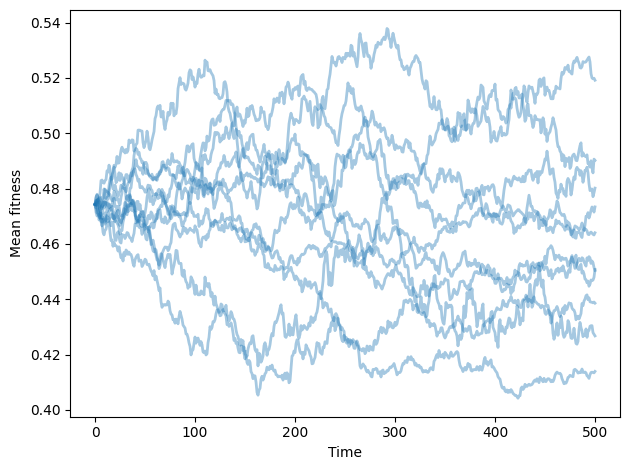

In [29]:
np.random.seed(17)

plot_sims(fit_land, agent_maker1, Simulation, MeanFitness, color='C0')
savefig('figs/chap11-1')

## Differential survival

We can add differential survival by overriding `choose_dead`

In [30]:
class SimWithDiffSurvival(Simulation):
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) > ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead

With differential survival, mean fitness increases and then levels off.

Saving figure to file figs/chap11-2


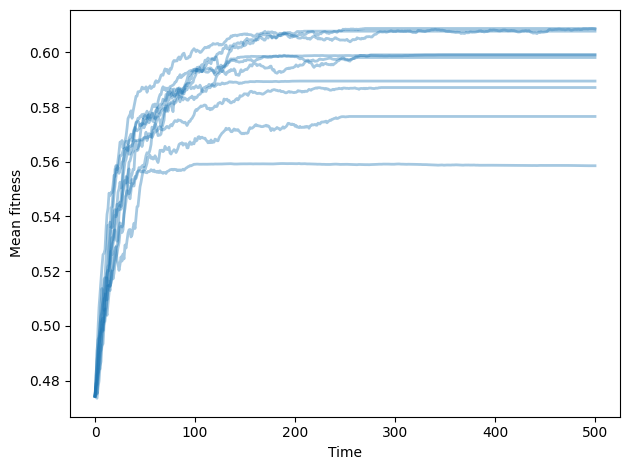

In [31]:
np.random.seed(17)

plot_sims(fit_land, agent_maker1, SimWithDiffSurvival, MeanFitness, color='C0')
savefig('figs/chap11-2')

We can add differential reproduction by overriding `choose_replacements`

In [32]:
class SimWithDiffReproduction(Simulation):

    def choose_replacements(self, n, weights):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        weights: array of weights
        
        returns: sequence of Agent objects
        """
        p = weights / np.sum(weights)
        agents = np.random.choice(self.agents, size=n, replace=True, p=p)
        replacements = [agent.copy() for agent in agents]
        return replacements

With differential reproduction (but not survival), mean fitness increases and then levels off.

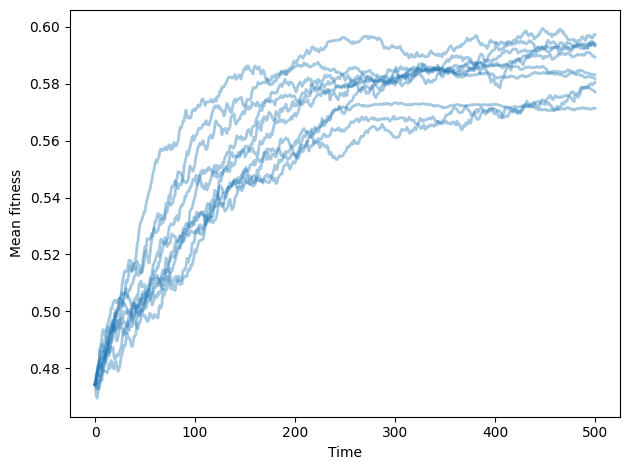

In [33]:
np.random.seed(17)

plot_sims(fit_land, agent_maker1, SimWithDiffReproduction, MeanFitness, color='C0');

**Exercise:** What if you have both?  Write a class called `SimWithBoth` that uses the new versions of `choose_dead` and `choose_replacements`.  Does mean fitness increase more quickly?

In [33]:
class SimWithBoth:
    

## Number of different agents

Without mutation, we have no way to add diversity.  The number of occupied locations goes down over time.

`OccupiedLocations` is an instrument that counts the number of occupied locations.

In [34]:
class OccupiedLocations(Instrument):
    label = 'Occupied locations'

    def update(self, sim):
        uniq_agents = len(set(sim.get_locs()))
        self.metrics.append(uniq_agents)

Here's what that looks like with no differential survival or reproduction.

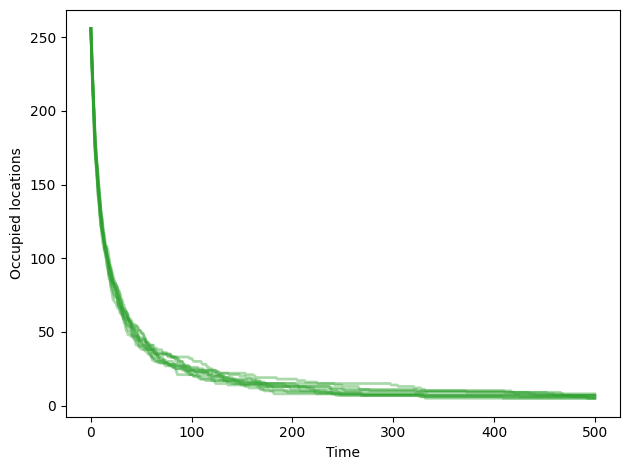

In [35]:
np.random.seed(17)

plot_sims(fit_land, agent_maker1, Simulation, OccupiedLocations, color='C2');

**Exercise:** What effect do differential survival and reproduction have on the number of occupied locations?

The model we have so far might explain changes in existing populations, but it doesn't explain increasing diversity or complexity.

## Mutation

Mutation is one way of increasing, or at least maintaining, diversity.

`Mutant` is a kind of agent that overrides `copy`:

In [36]:
class Mutant(Agent):
    
    def copy(self, prob_mutate=0.05):
        if np.random.random() > prob_mutate:
            loc = self.loc.copy()
        else:
            direction = np.random.randint(self.fit_land.N)
            loc = self.mutate(direction)
        return Mutant(loc, self.fit_land)
    
    def mutate(self, direction):
        """Computes the location in the given direction.
        
        Result differs from the current location along the given axis.
        
        direction: int index from 0 to N-1
        
        returns: new array of N 0s and 1s
        """
        new_loc = self.loc.copy()
        new_loc[direction] ^= 1
        return new_loc

To test it out, I'll create an agent at a random location.

In [37]:
N = 8
fit_land = FitnessLandscape(N)
loc = fit_land.random_loc()
agent = Mutant(loc, fit_land)
agent.loc

array([1, 1, 1, 1, 0, 0, 1, 0], dtype=int8)

If we make 20 copies, we expect about one mutant.

In [38]:
for i in range(20):
    copy = agent.copy()
    print(fit_land.distance(agent.loc, copy.loc))

0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0


`agent_maker2` makes identical agents.

In [39]:
def agent_maker2(fit_land):
    agents = make_identical_agents(fit_land, 100, Mutant)
    return agents

If we start with identical mutants, we still see increasing fitness.

Saving figure to file figs/chap11-3


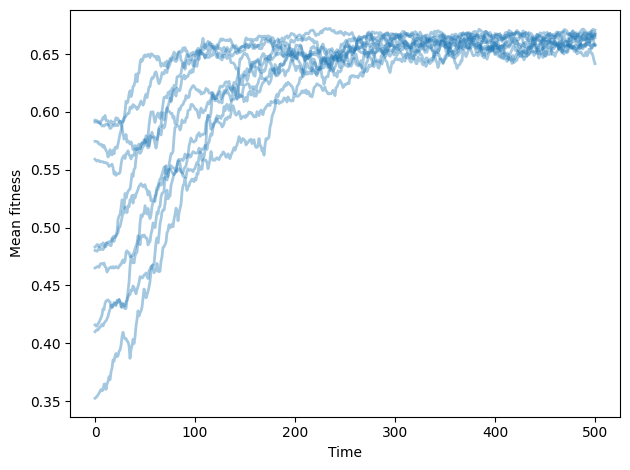

In [50]:
np.random.seed(17)

sim = plot_sims(fit_land, agent_maker2, SimWithBoth, MeanFitness, color='C0')
savefig('figs/chap11-3')

And now the number of occupied locations increases, reaching a steady state at about 10.

In [41]:
np.random.seed(17)

sim = plot_sims(fit_land, agent_maker2, 
                SimWithBoth, OccupiedLocations, 
                color='C2', linewidth=1)
savefig('figs/chap11-4')

NameError: name 'SimWithBoth' is not defined

In steady state, many agents are at the optimal location, and others are usually just a few mutations away.  To quantify that, we can compute the mean distance between all pairs of agents.

The distance between two agents is the number of bit flips to get from one location to another.

In [42]:
class MeanDistance(Instrument):
    """Computes mean distance between pairs at each timestep."""
    label = 'Mean distance'
        
    def update(self, sim):
        N = sim.fit_land.N
        i1, i2 = np.triu_indices(N)
        agents = zip(sim.agents[i1], sim.agents[i2])
        
        distances = [fit_land.distance(a1.loc, a2.loc)
                     for a1, a2 in agents if a1 != a2]
        
        mean = np.mean(distances)
        self.metrics.append(mean)

Mean distance is initially 0, when all agents are identical.  It increases as the population migrates toward the optimal location, then settles into a steady state around 1.5.

In [43]:
np.random.seed(17)

fit_land = FitnessLandscape(10)
agents = make_identical_agents(fit_land, 100, Mutant)
sim = SimWithBoth(fit_land, agents)
sim.add_instrument(MeanDistance())
sim.run(500)
sim.plot(0, color='C1')
decorate(xlabel='Time', ylabel='Mean distance')
savefig('figs/chap11-5')

NameError: name 'SimWithBoth' is not defined

### Changing landscape

One cause of speciation is a change in the landscape.  Suppose a population in steady state in one landscape is transported to another landscape.  After a period of migration, it would settle around the new equilibrium point, with a small mean distance between agents.  The mean distance between the original agents and the migrants is generally much larger.

The following simulation runs 500 steps on one landscape, then switches to a different landscape and resumes the simulation.

In [44]:
np.random.seed(17)

fit_land = FitnessLandscape(10)
agents = make_identical_agents(fit_land, 100, Mutant)
sim = SimWithBoth(fit_land, agents)
sim.add_instrument(MeanFitness())
sim.add_instrument(OccupiedLocations())
sim.add_instrument(MeanDistance())
sim.run(500)
locs_before = sim.get_locs()
fit_land.set_values()
sim.run(500)
locs_after = sim.get_locs()

NameError: name 'SimWithBoth' is not defined

After the switch to a new landscape, mean fitness drops briefly, then the population migrates to the new optimal location, which happens to be higher, in this example.

In [45]:
vline_options = dict(color='gray', linewidth=2, alpha=0.4)

Saving figure to file figs/chap11-6


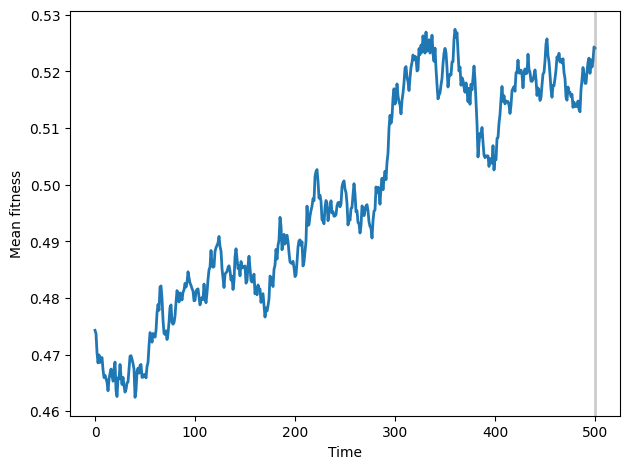

In [46]:
sim.plot(0, color='C0')
plt.axvline(500, **vline_options)
decorate(xlabel='Time', ylabel='Mean fitness')
savefig('figs/chap11-6')

The number of occupied locations (sometimes) increases while the population is migrating.

In [47]:
sim.plot(1, color='C2')
plt.axvline(500, **vline_options)
decorate(xlabel='Time', ylabel='Occupied locations')

IndexError: list index out of range

And the mean distance (sometimes) increases until the population reaches the new steady state.

In [48]:
sim.plot(2, color='C1')
plt.axvline(500, **vline_options)
decorate(xlabel='Time', ylabel='Mean distance')

IndexError: list index out of range

The mean distance between clusters is much bigger than the dispersion within clusters, so we can interpret the clusters as distinct species.

In [49]:
distances = []
for loc1 in locs_before:
    for loc2 in locs_after:
        distances.append(fit_land.distance(loc1, loc2))
np.mean(distances)

NameError: name 'locs_before' is not defined

**Exercise:** When we change the landscape, the number of occupied locations and the mean distance usually increase, but the effect is not always big enough to be obvious.  You might want to try out some different random seeds to see how general the effect is.